In [134]:
import json
from pandas.io.json import json_normalize

import numpy
# from sklearn.feature_extraction.text import DictVectorizer
from matplotlib import pyplot
%matplotlib inline

from sklearn.feature_extraction import DictVectorizer
from sklearn import linear_model
from sklearn import cross_validation

In [3]:
with open('/Users/regata/Downloads/properties.json', 'rt') as f:
    data = json.load(f)
    
data_arr = map(lambda x: data[x], data.keys())

In [79]:
# flatten json into dataframe
df = json_normalize(data_arr)
print(df.shape)
df.head(20).T

(6916, 98)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
% dif,118,102,104,93,99,108,108,98,99,125,93,95,102,113,95,99,108,100,105,110
address.city,toronto,georgina,toronto,toronto,brampton,markham,toronto,brampton,toronto,toronto,toronto,toronto,ajax,brock,brampton,mississauga,oakville,brampton,toronto,toronto
address.neighbourhood,dovercourt-wallace emerson-junction,keswick south,glenfield-jane heights,dorset park,credit valley,cornell,humberlea-pelmo park w5,fletcher's meadow,mount pleasant east,cliffcrest,malvern,scarborough village,south east,sunderland,queen street corridor,erindale,glen abbey,fletcher's west,high park-swansea,alderwood
address.postal code,M6H1W5,L4P4B3,M3L2A8,M1P4V3,L640Z2,L6B1G4,M9M0E3,L7A3L8,M4S 1A5,M1M2C5,M1B4Z3,M1M3T7,L1S7T3,L0C 1H0,L6S5K7,L5C2Z3,L6M1A6,L6Y4L3,M6S3E7,M8W 3T2
address.province,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario,ontario
address.street,53 hallam st,36 glasgow cres,25 whitbread cres,301 prudential dr,30 kimborough hllw,16 northvale rd,29 betty nagle st,22 sugarhill dr,319 merton st,54 colonial ave,8 silverbell grve,91 muir dr,1 langsdorff dr,2175 concession 5 rd,22 hanover rd,830 stainton dr,1228 old post dr,149 torrance wood,99 durie st,138 browns line
apx age.label,NaN,6-15,NaN,31-50,0-5,6-15,0-5,NaN,6-10,NaN,6-15,NaN,NaN,NaN,16-30,NaN,31-50,NaN,NaN,31-50
apx age.val,NaN,15,NaN,50,5,15,5,NaN,10,NaN,15,NaN,NaN,NaN,30,NaN,50,NaN,NaN,50
apx sqft.label,1500-2000,1500-2000,NaN,800-899,1500-2000,NaN,NaN,NaN,600-699,NaN,1000-1199,1200-1399,NaN,1100-1500,1000-1199,1200-1399,2000-2500,3000-3500,NaN,NaN
apx sqft.val,2000,2000,NaN,899,2000,NaN,NaN,NaN,699,NaN,1199,1399,NaN,1500,1199,1399,2500,3500,NaN,NaN


In [80]:
# exclude any non-sale properties
df = df[df['detail.for'] == 'sale']

df['price_diff'] = df['sold'] - df['list']

# exclude missing sold or list prices
df = df[df['price_diff'].notnull()]

# exclude price outliers
df['price_ratio'] =  df['price_diff'] / df['list']
df = df[df['price_ratio'] < 1]

# exclude missing property_type
df = df[df['property_type'].notnull()]

df.shape

(6114, 100)

In [82]:
# fill missing values
df['apx age.val'].fillna(0, inplace=True)
df['apx sqft.val'].fillna(0, inplace=True)

df['bedrooms'] = df['bedrooms.val'] + df['bedrooms.plus']
df['bedrooms'].fillna(0, inplace=True)

df['rooms'] = df['rms.val'] + df['rms.plus']
df['rooms'].fillna(0, inplace=True)

df['kitchens'] = df['kitchens.val'] + df['kitchens.plus']
df['kitchens'].fillna(0, inplace=True)

df['washrooms'].fillna(0, inplace=True)

df['maint'].fillna(0, inplace=True)
df['taxes'].fillna(0, inplace=True)

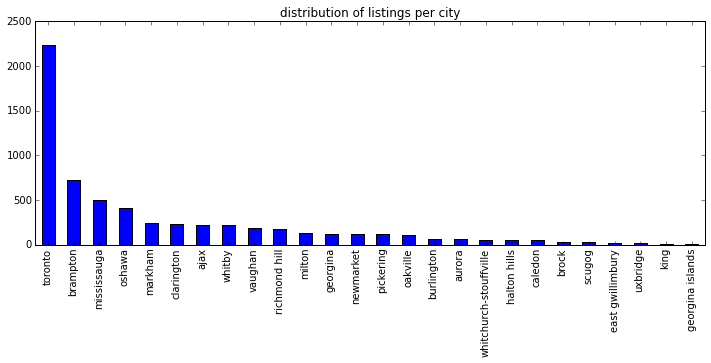

In [83]:
ax = df['address.city'].value_counts().plot(kind='bar', figsize=(12,4))
ax.set_title('distribution of listings per city')

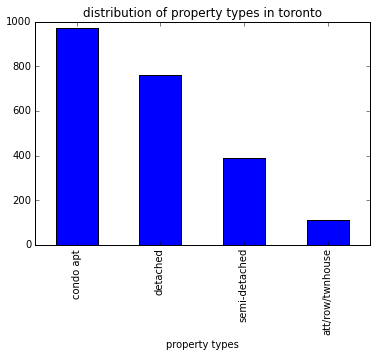

In [84]:
df_toronto = df[df['address.city'] == 'toronto']
ax = df_toronto['property_type'].value_counts().plot(kind='bar')
ax.set_xlabel('property types')
ax.set_title('distribution of property types in toronto')

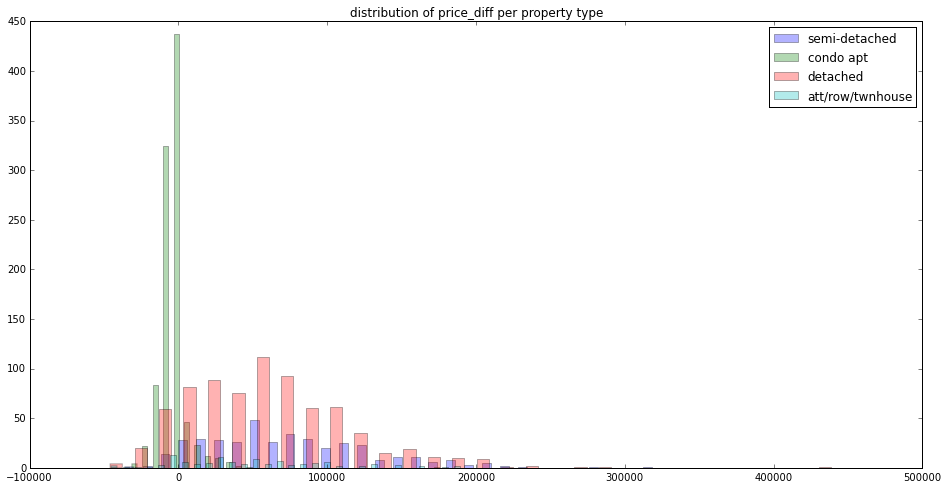

In [85]:
property_types = df_toronto['property_type'].unique()

fig = pyplot.figure(figsize=(16,8))
for pt in property_types:
    ratios = df_toronto[df_toronto['property_type'] == pt]['price_diff'].values
    counts, bins = numpy.histogram(ratios, bins=30)
    ax = pyplot.hist(ratios, bins, alpha=0.3, label=pt, rwidth=0.5)

pyplot.legend(loc='upper right')
pyplot.title('distribution of price_diff per property type')
pyplot.show()

In [105]:
features_df = df_toronto[['property_type',
                 'apx age.val',
                 'bedrooms',
                 'rooms',
                 'kitchens',
                 'washrooms',
                 'maint',
                 'taxes',
                 'list']]
features_df.head(20)

,property_type,apx age.val,bedrooms,rooms,kitchens,washrooms,maint,taxes,list
2,semi-detached,0,3,9,2,2,0.00,2498.00,498900
3,condo apt,50,2,5,1,1,502.34,1200.00,145000
6,semi-detached,5,4,8,1,3,0.00,2694.56,559000
8,condo apt,10,2,4,1,1,465.27,2466.62,383900
9,detached,0,6,11,2,3,0.00,2577.53,599900
10,condo apt,15,3,6,1,2,671.52,874.84,148000
18,detached,0,3,8,1,2,0.00,4385.06,799000
22,condo apt,30,2,6,1,2,620.29,1170.00,158000
24,condo apt,0,1,3,1,1,280.85,960.00,229000
26,semi-detached,0,2,5,1,1,0.00,1908.74,339900


In [135]:
dict_vectorizer = DictVectorizer(dtype=int, sparse=False)

features_list = features_df.to_dict(orient='records')
X = dict_vectorizer.fit_transform(features_list)
print(X.shape)
dict_vectorizer.get_feature_names()

(2231, 12)


['apx age.val',
 'bedrooms',
 'kitchens',
 u'list',
 u'maint',
 u'property_type=att/row/twnhouse',
 u'property_type=condo apt',
 u'property_type=detached',
 u'property_type=semi-detached',
 'rooms',
 u'taxes',
 u'washrooms']

In [136]:
Y = df_toronto['sold'].values
Y.shape

(2231,)

In [137]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.1, random_state=0)

In [155]:
clf = linear_model.LinearRegression(fit_intercept=False, normalize=False)
clf.fit (X_train, y_train)
clf.coef_

array([  3.87555538e+01,   5.68003684e+02,  -5.20086124e+02,
         9.98609096e-01,  -3.47546702e+00,   1.67997259e+04,
        -2.06783673e+04,   2.36862894e+04,   3.68558999e+04,
         8.22886040e+02,   1.26556590e+01,  -4.63533458e+03])

In [156]:
clf.score(X_test, y_test)

0.97012393950011011

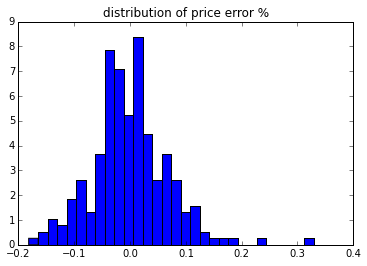

In [168]:
y_pred = clf.predict(X_test)

error_perc = (y_test - y_pred) / y_test
pyplot.hist(error_perc, bins=30, normed=True)
pyplot.title('distribution of price error %')
pyplot.show()

In [135]:
# http://mrloft.ca/Toronto-MLS-district-Map
# Google maps
# https://www.wakari.io/sharing/bundle/wakari_demo/realtime_twitter_analysis?has_login=False
# http://stackoverflow.com/questions/11761738/how-can-i-make-a-google-maps-api-v3-hexagon-tiled-map-preferably-coordinate-bas
# http://econym.org.uk/gmap/example_eshapes.html
# http://www.machinalis.com/blog/embedding-interactive-maps-into-an-ipython-nb/
# http://scikit-learn.org/stable/modules/feature_extraction.html